Импортируем нужные для работы библиотеки

In [1]:
import seaborn as sns
import pandas as pd                                                            # модуль для работы с датафреймами
import numpy as np                                                             # модуль для работы с массивами
import matplotlib.pyplot as plt                                                # модуль для визуализации результатов
from sklearn.model_selection import TimeSeriesSplit, cross_val_score           # модули с метриками
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Загружаем и проводим работу с данными

In [2]:
# Чтение CSV файлов
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Переименование колонки "Цена на арматуру" на "price"
train_df.rename(columns={'Цена на арматуру': 'price'}, inplace=True)
test_df.rename(columns={'Цена на арматуру': 'price'}, inplace=True)

# Преобразование колонки "Data" в формат datetime
train_df['dt'] = pd.to_datetime(train_df['dt'])
test_df['dt'] = pd.to_datetime(test_df['dt'])

# Объединение двух DataFrame
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Сохранение объединенного DataFrame в новый CSV файл
combined_df.to_csv('combined.csv', index=False)

print("Объединение завершено. Результат сохранен в 'combined.csv'.")

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

Выводим динамику цена на арматуру

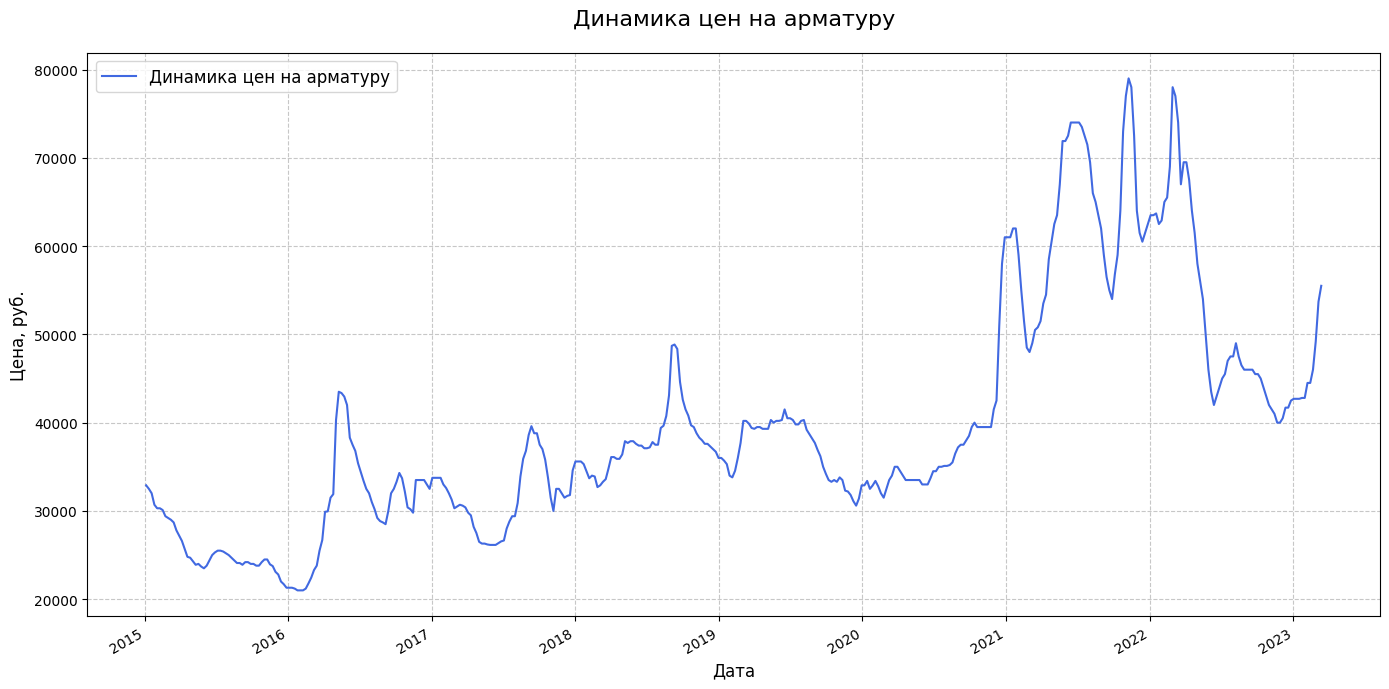

In [ ]:
# Построение графика динамики цен
plt.figure(figsize=(14, 7))
sns.lineplot(data=combined_df, x='dt', y='price', 
             label='Динамика цен на арматуру', color='royalblue')

plt.title('Динамика цен на арматуру', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена, руб.', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Форматирование дат на оси X
plt.gcf().autofmt_xdate()

# Добавление легенды
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('price_dynamics.png', dpi=300)
plt.show()

Делаем проверку на стационарность

Анализ стационарности временного ряда


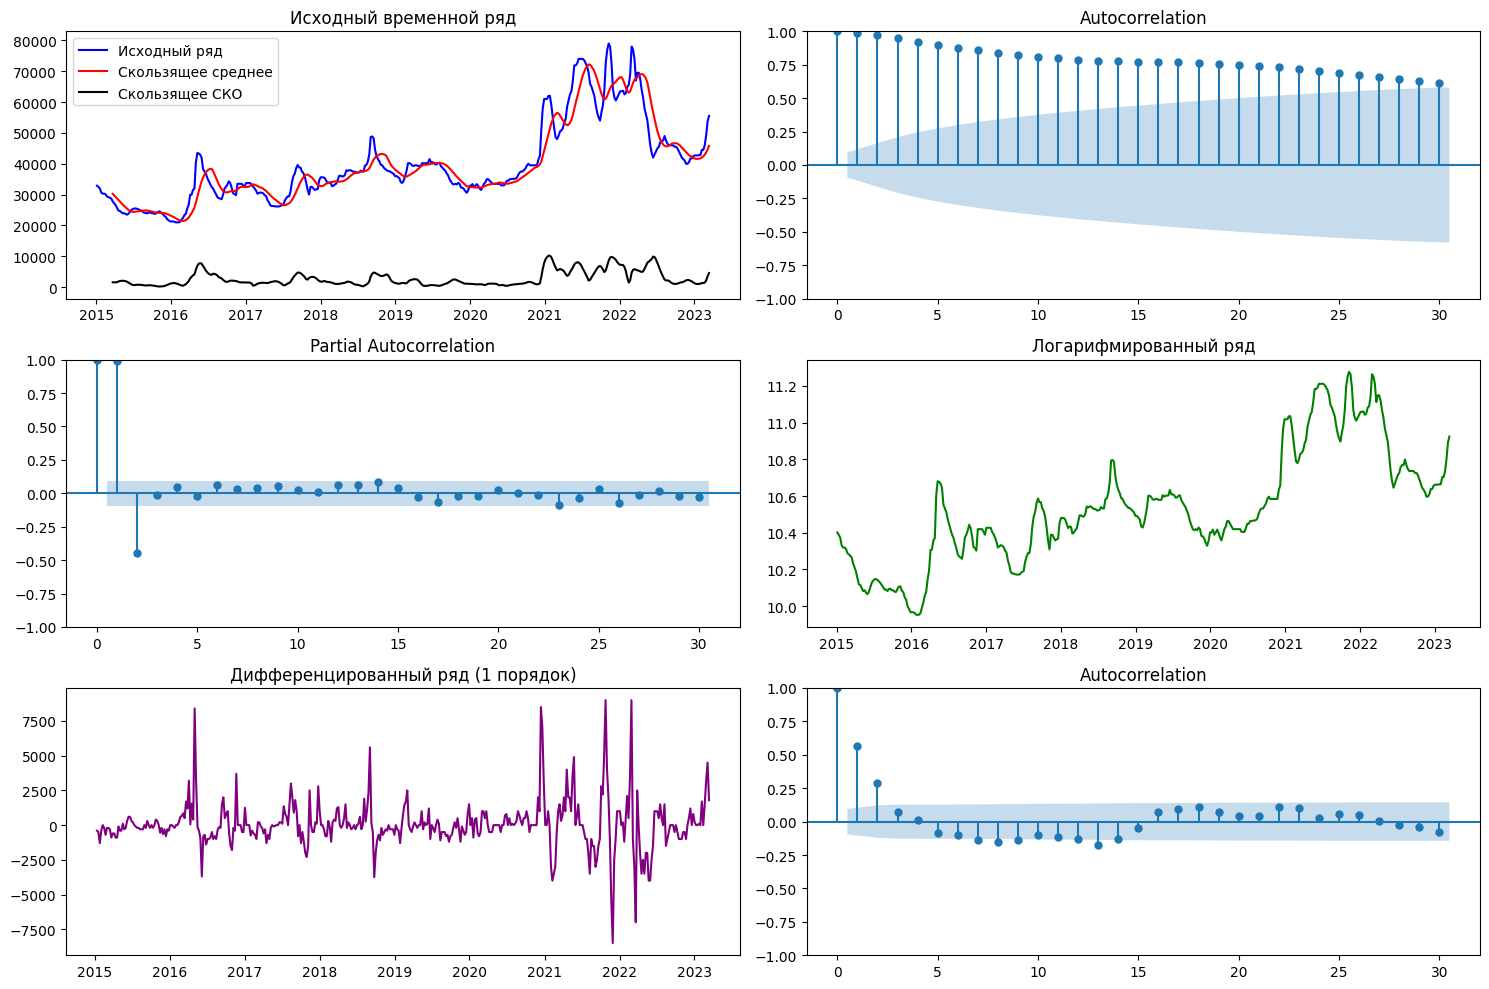


Результаты теста Дики-Фуллера:

Исходный ряд:
Тестовая статистика            -1.906195
p-value                         0.329152
Количество лагов                5.000000
Количество наблюдений         422.000000
Критическое значение (1%)      -3.445941
Критическое значение (5%)      -2.868413
Критическое значение (10%)     -2.570431
dtype: float64
Вывод: Ряд нестационарен

Логарифмированный:
Тестовая статистика            -1.592924
p-value                         0.487147
Количество лагов                8.000000
Количество наблюдений         419.000000
Критическое значение (1%)      -3.446054
Критическое значение (5%)      -2.868463
Критическое значение (10%)     -2.570458
dtype: float64
Вывод: Ряд нестационарен

Дифференцированный:
Тестовая статистика          -7.754587e+00
p-value                       9.814436e-12
Количество лагов              1.200000e+01
Количество наблюдений         4.140000e+02
Критическое значение (1%)    -3.446244e+00
Критическое значение (5%)    -2.868547e+00


In [ ]:
def load_and_prepare_data():
    """Загрузка и подготовка данных"""
    file_path = 'train.csv'
    df = pd.read_csv(file_path)
    
    # Предполагаем, что данные содержат колонки 'dt' (дата) и 'price' (цена)
    df['dt'] = pd.to_datetime(df['dt'])
    df.set_index('dt', inplace=True)
    return df['price'].dropna()

def test_stationarity(timeseries, window=12):
    """Тест Дики-Фуллера и визуализация"""
    # Вычисление скользящей статистики
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    # График временного ряда
    plt.figure(figsize=(15, 10))
    
    # Оригинальный ряд
    plt.subplot(3, 2, 1)
    plt.plot(timeseries, color='blue', label='Исходный ряд')
    plt.plot(rolmean, color='red', label='Скользящее среднее')
    plt.plot(rolstd, color='black', label='Скользящее СКО')
    plt.legend()
    plt.title('Исходный временной ряд')
    
    # ACF/PACF оригинального ряда
    plt.subplot(3, 2, 2)
    plot_acf(timeseries, lags=30, ax=plt.gca())
    plt.subplot(3, 2, 3)
    plot_pacf(timeseries, lags=30, ax=plt.gca())
    
    # Логарифмирование
    log_series = np.log(timeseries)
    plt.subplot(3, 2, 4)
    plt.plot(log_series, color='green')
    plt.title('Логарифмированный ряд')
    
    # Дифференцирование
    diff_series = timeseries.diff().dropna()
    plt.subplot(3, 2, 5)
    plt.plot(diff_series, color='purple')
    plt.title('Дифференцированный ряд (1 порядок)')
    
    # ACF/PACF дифференцированного ряда
    plt.subplot(3, 2, 6)
    plot_acf(diff_series, lags=30, ax=plt.gca())
    
    plt.tight_layout()
    plt.show()
    
    # Тест Дики-Фуллера
    print('\nРезультаты теста Дики-Фуллера:')
    for name, series in [('Исходный ряд', timeseries),
                         ('Логарифмированный', log_series),
                         ('Дифференцированный', diff_series)]:
        dftest = adfuller(series, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Тестовая статистика', 'p-value', 
                                                'Количество лагов', 'Количество наблюдений'])
        for key, value in dftest[4].items():
            dfoutput[f'Критическое значение ({key})'] = value
        print(f'\n{name}:')
        print(dfoutput)
        print(f"Вывод: {'Ряд стационарен' if dfoutput['p-value'] < 0.05 else 'Ряд нестационарен'}")

def main():
    """Основная функция"""
    print("Анализ стационарности временного ряда")
    series = load_and_prepare_data()
    test_stationarity(series)

if __name__ == "__main__":
    main()